In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [5]:
BASE_DIR='/kaggle/input/flickr8k'
WORKING_DIR='/kaggle/working'

## EXTRACTING FEATURES

In [4]:
#load vgg16
model=VGG16()
#restructure

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

#summarize
print(model.summary())

I0000 00:00:1753717465.113743      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753717465.114561      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
#extract features from image
features = {}
directory=os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    #load image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    #convert image pixels to np array
    image=img_to_array(image)
    #reshape data for model to extract features
    image=image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #preprocess image for vgg
    image=preprocess_input(image)
    #extract features
    feature=model.predict(image, verbose=0)
    #get image id
    image_id=img_name.split('.')[0]
    #store feature
    features[image_id] = feature

In [ ]:
#store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
#load features from pickle
with open('/kaggle/input/preprocesed/features.pkl', 'rb') as f:
    features = pickle.load(f)

## LOAD THE CAPTIONS DATA

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f) #skips first line
    captions_doc = f.read()

In [ ]:
#create mapping of image to caption

mapping = {}

#process lines
for line in tqdm(captions_doc.split('\n')):
    #split the line by comma
    tokens = line.split(',')
    if(len(line) < 2):
        continue
    image_id, caption = tokens[0], tokens[1:]
    #remove extention from img id
    image_id = image_id.split('.')[0]
    #convert captions list to a string 
    caption = " ".join(caption)
    #create list if needed
    if image_id not in mapping:
        mapping[image_id]=[]
    #store caption
    mapping[image_id].append(caption)

In [ ]:
len(mapping)

In [ ]:
#store features in pickle
pickle.dump(mapping, open(os.path.join(WORKING_DIR, 'mapping.pkl'), 'wb'))

In [7]:
#load features from pickle
with open('/kaggle/input/preprocesed/mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)

## PREPROCESS TEXT DATA

In [8]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            #take one caption at a time
            caption = captions[i]
            caption = caption.lower() #converts to lower case
            caption = caption.replace('[^A-Za-z]','') #only keeps characters
            caption = caption.replace('\s+',' ') #replace multiple spcaes with one
            #add start amd end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq' #removes smaller words like a
            captions[i] = caption

In [9]:
#before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [10]:
#preprocess the text
clean(mapping)

In [11]:
#after preprocessing
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [12]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [13]:
len(all_captions)

40455

In [14]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [15]:
#tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [16]:
vocab_size

8485

In [17]:
#get maximum length of the caption available helps in padding
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## TRAIN TEST SPLIT

In [18]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.9)
split

7281

In [19]:
train = image_ids[:split]
test = image_ids[split:]

In [20]:
# create data generator to get data in batch
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    #lookover images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n+=1
            captions = mapping[key]
            for caption in captions: #process each caption
                #encode each sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split sequence into X, y pairs
                for i in range(1, len(seq)):
                    #split into input output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    #pad input sequences
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    #encode the output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    #store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n=0
                

## MODEL CREATION

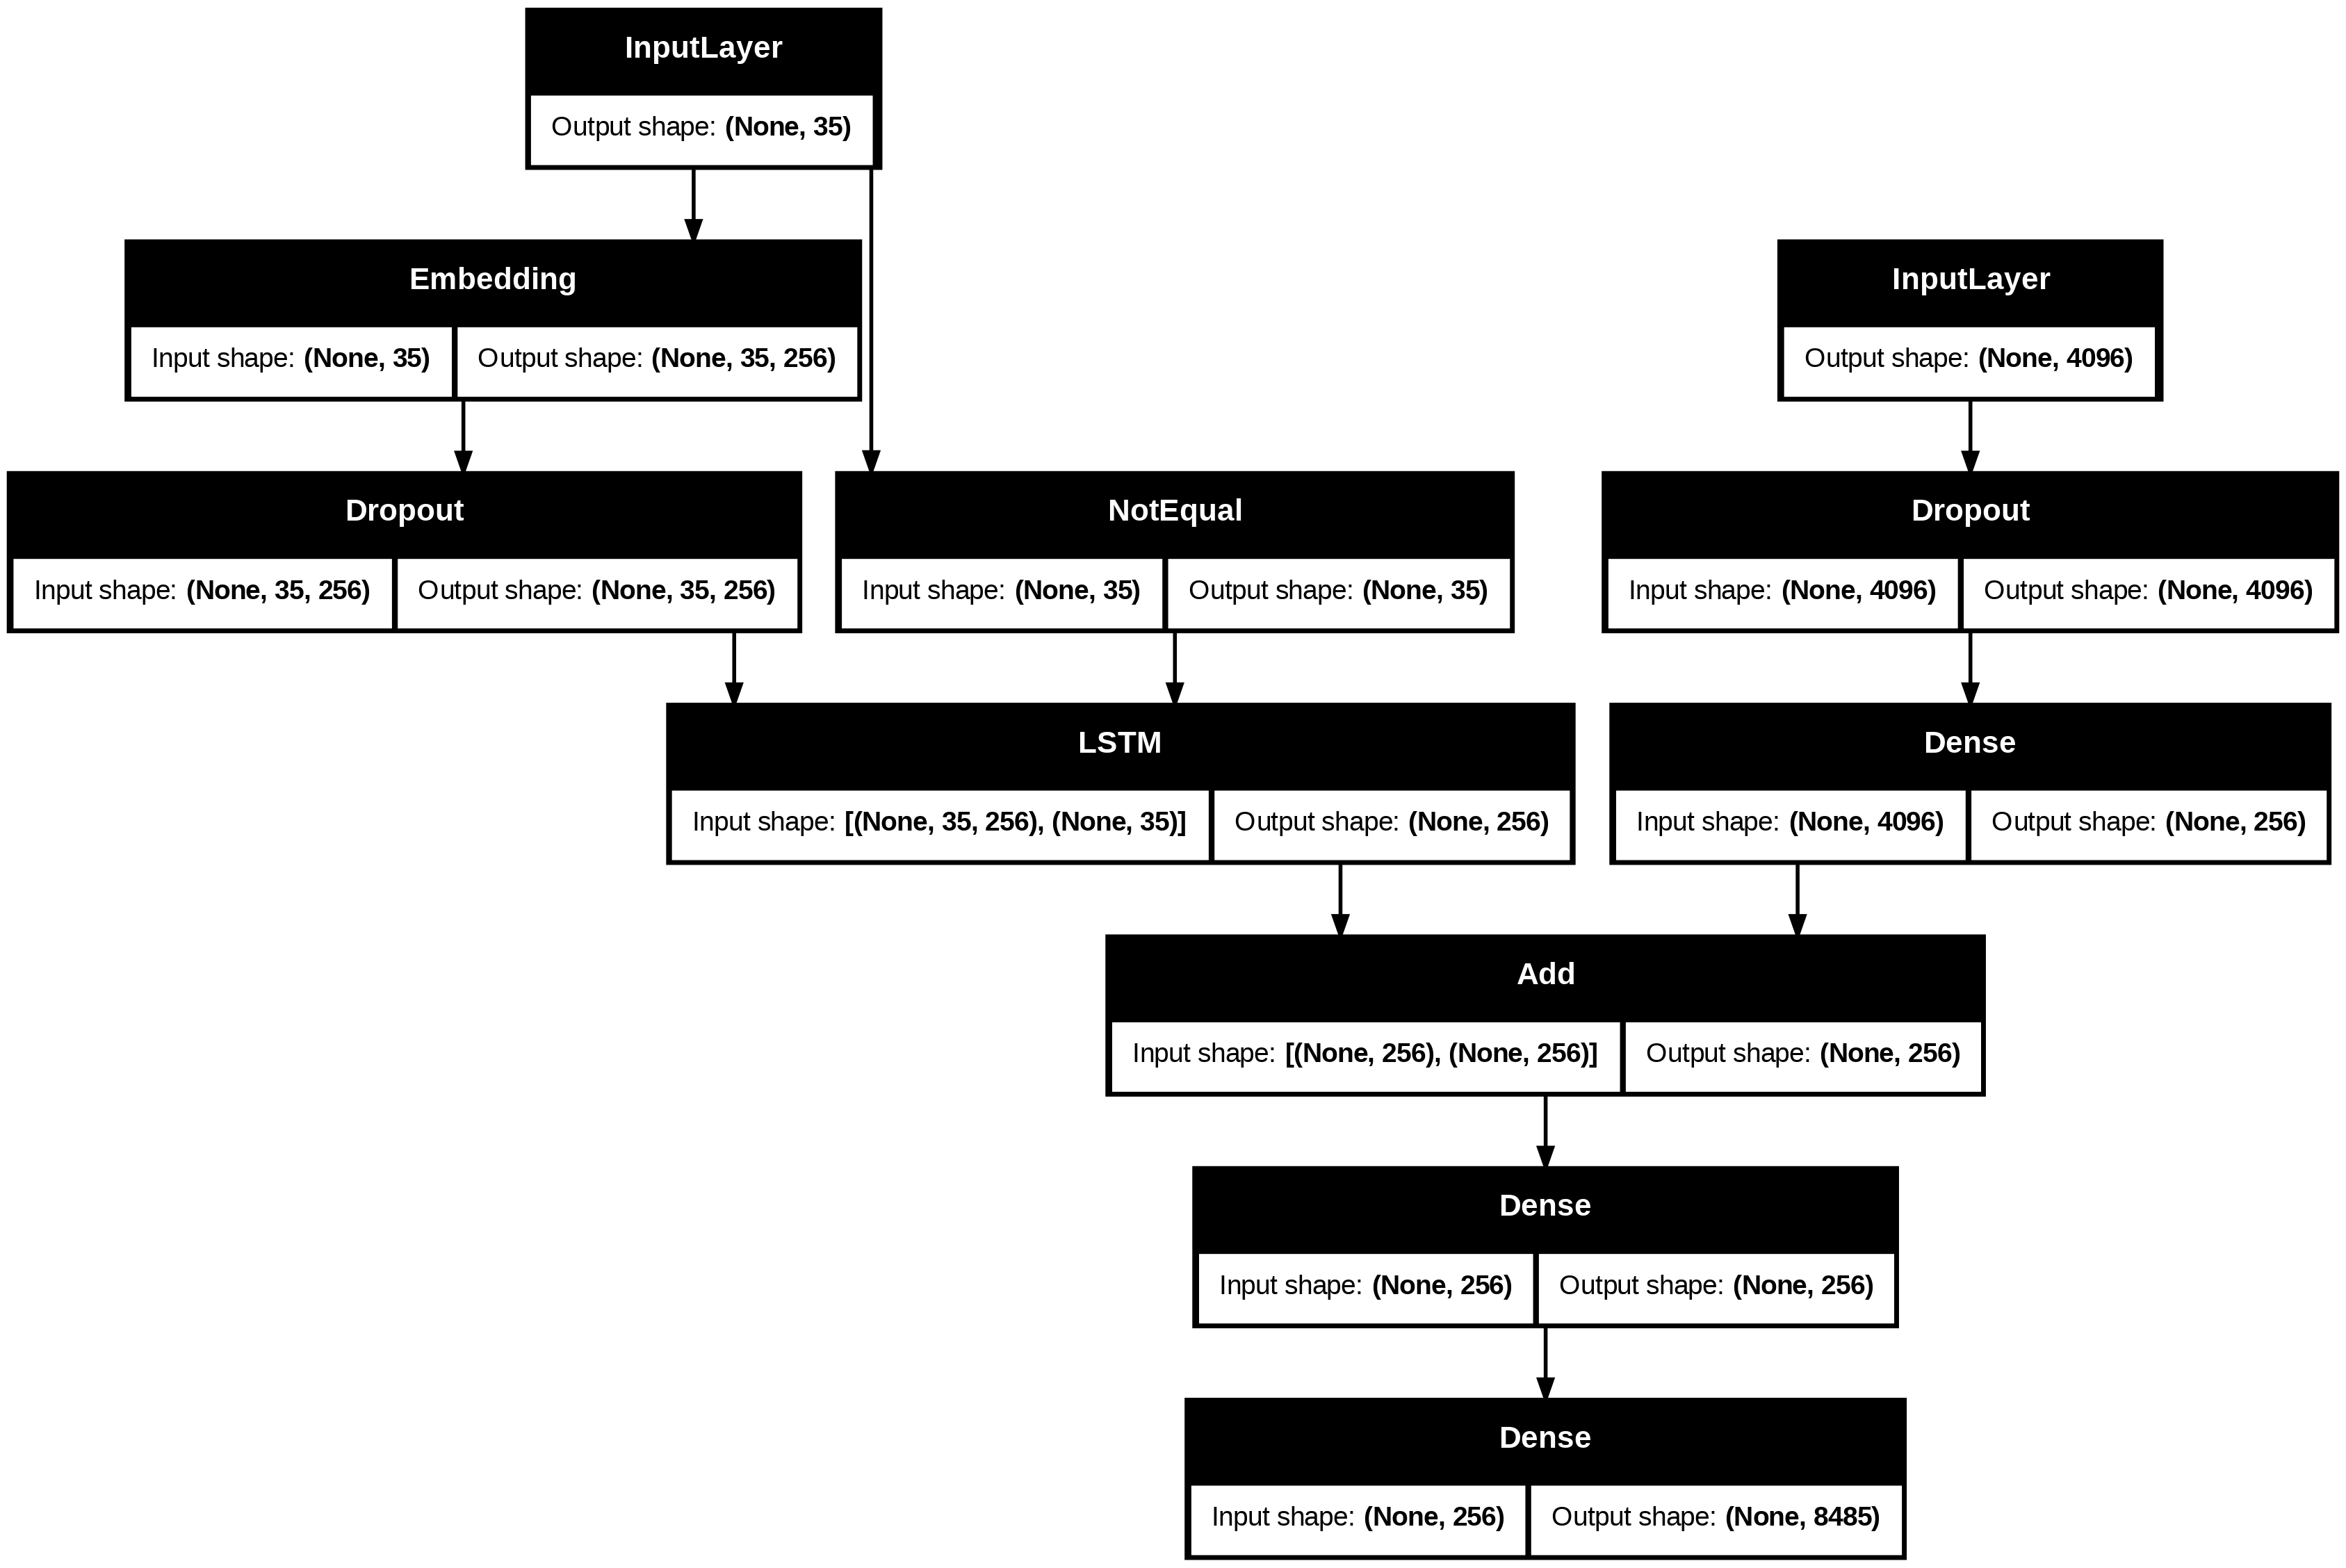

In [21]:
#encoder model

#image feature layer
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
#sequence feature layer
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)

#decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

#plot model
plot_model(model, show_shapes=True)

In [29]:
#train the model
epochs = 5
batch_size = 32
steps = len(train) // batch_size


for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    #fit one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 248ms/step - loss: 1.8611
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - loss: 1.8497
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 251ms/step - loss: 1.8297
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 251ms/step - loss: 1.8183
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 251ms/step - loss: 1.8066


In [30]:
model.save(WORKING_DIR+'/final_model.h5')

## GENERATE CAPTIONS FOR THE IMAGE

In [31]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [32]:
#generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    #add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of the sequence 
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose = 0)
        # get index with the higher probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
    
        if word is None:
            break
        # append word as input for generating next word
        in_text +=" " + word
        #stop if we reach end tag
        if word == 'endseq' :
            break

    return in_text


In [33]:
from nltk.translate.bleu_score import corpus_bleu
#calculate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calculate BLEU score
print("BLEU-1 :%f" % corpus_bleu(actual, predicted, weights=(1, 0, 0, 0)))
print("BLEU-2 :%f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1 :0.529900
BLEU-2 :0.304453


## VISUALIZE THE RESULTS

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    
    print("ACTUAL")
    for caption in captions:
        print(caption)

    #predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print("PREDICTED")
    print(y_pred)
    plt.imshow(image)

ACTUAL
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
PREDICTED
startseq the woman is sitting on the stairs endseq


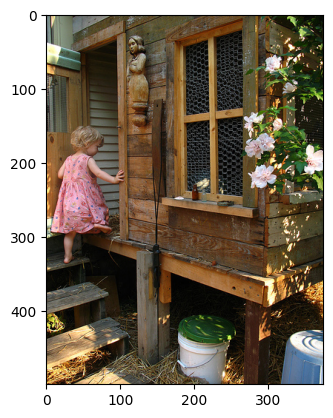

In [35]:
generate_caption("1000268201_693b08cb0e.jpg")